# Setup

In [1]:
%pip install imageio
%pip install pyvirtualdisplay
%pip install tf-agents
%pip install pyglet

     |████████████████████████████████| 3.4 MB 2.9 MB/s            
     |████████████████████████████████| 3.3 MB 44.3 MB/s            
     |████████████████████████████████| 18.1 MB 10.8 MB/s            
You should consider upgrading via the '/Users/ribeirg/Documents/pessoal/tg/git/learning-tg-agents/venvIntelliJ/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
  Using cached PyVirtualDisplay-3.0-py3-none-any.whl (15 kB)
You should consider upgrading via the '/Users/ribeirg/Documents/pessoal/tg/git/learning-tg-agents/venvIntelliJ/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 1.4 MB 2.9 MB/s            
     |████████████████████████████████| 124 kB 60.1 MB/s            
     |████████████████████████████████| 6.7 MB 53.1 MB/s            
  Using cached wrapt-1.14.1-cp39-cp39-macosx_10_9_x86_64.whl (35 kB)
  U

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay
import numpy as np

import tensorflow as tf
import tf_agents as tfa

# Seed for PPO actor network
import tensorflow_probability as tfp

# PPO Agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.agents.ppo import ppo_actor_network
from tf_agents.networks import value_network
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ppo import ppo_clip_agent

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.networks import sequential

# old agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network


from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Hyperparameters

In [15]:

# register(
#     id='CartPole-v1',
#     entry_point='gym.envs.classic_control:CartPoleEnv',
#     max_episode_steps=500,
#     reward_threshold=475.0,
# )

env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 5000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (64,64)

batch_size = 64  # @param {type:"integer"}
learning_rate = 3e-4  # @param {type:"number"}
gamma = 0.99


log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


actor_fc_layers = (8,16,32,64,128,64,32,16,8,4,2)
value_fc_layers = (8,16,32,64,128,64,128,64,32,16,8,4,2)

# Environment

In [16]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

observation_tensor_spec = tensor_spec.from_spec(train_env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
time_step_tensor_spec = tensor_spec.from_spec(train_env.time_step_spec())

In [17]:
print('Observation: {0}'.format(observation_tensor_spec))
print('Action: {0}'.format(action_tensor_spec))
print('TimeStep: {0}'.format(time_step_tensor_spec))

Observation: BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))
Action: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))
TimeStep: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


# Agent

Netowork

In [18]:
# actor_net_builder = ppo_actor_network.PPOActorNetwork()
# actor_net = actor_net_builder.create_sequential_actor_net(
#     actor_fc_layers, action_tensor_spec)


actor_fc_layers = (64,64)
value_fc_layers = (64,64)

actor_net = actor_distribution_network.ActorDistributionNetwork(
        observation_tensor_spec,
        action_tensor_spec,
        fc_layer_params=actor_fc_layers,
        activation_fn=tf.nn.tanh,
        kernel_initializer=tf.keras.initializers.Orthogonal(seed=1),
        # seed_stream_class=DeterministicSeedStream,
        seed_stream_class=tfp.util.SeedStream
)

value_net = value_network.ValueNetwork(
    observation_tensor_spec,
    fc_layer_params=value_fc_layers,
    kernel_initializer=tf.keras.initializers.Orthogonal()
)

Optimizer

In [19]:
print(observation_tensor_spec)
print(action_tensor_spec)
print(time_step_tensor_spec)

BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))
TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [20]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent_ppo = ppo_agent.PPOAgent(
    time_step_spec=time_step_tensor_spec,
    action_spec=action_tensor_spec,
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter
    # compute_value_and_advantage_in_train=True,
    # update_normalizers_in_train=False,
    # num_epochs=10
)
agent_ppo.initialize()

# Metrics and Evaluation

In [21]:
train_env.current_time_step()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01432419, -0.0279336 ,  0.04301443,  0.01094299]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [22]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(
    time_step_tensor_spec,
    action_tensor_spec,
    info_spec=time_step_tensor_spec)

def evaluate_policy(policy):
  for _ in range(1):
    avg= compute_avg_return(eval_env, policy, num_eval_episodes)
    print(avg)

# evaluate_policy(random_policy)

# evaluate_policy(agent_ppo.policy)

evaluate_policy(agent_ppo.collect_policy)


35.4


In [23]:
a = np.array(1)

# print(a.shape)
data_spec =  (
        tf.TensorSpec([3], tf.float32, 'action'),
        (
            tf.TensorSpec([5], tf.float32, 'lidar'),
            tf.TensorSpec([3, 2], tf.float32, 'camera')
        )
)
# print(data_spec)
print(agent_ppo.collect_policy.trajectory_spec)
print(agent_ppo.policy.trajectory_spec)

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': {'dist_params': {'logits': TensorSpec(shape=(2,), dtype=tf.float32, name='CategoricalProjectionNetwork_logits')}},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=

# Data Collection

In [28]:
agent_ppo.policy.trajectory_spec


Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [42]:
# ds = (64,)
batch_size = 100

initial_collect_steps=1

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent_ppo.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=100)

def collect_step(environment, policy):
    b_traj = []
    for i in range(batch_size):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)
        b_traj.append(traj)
    values_batched = tf.nest.map_structure(lambda t: tf.stack(t), b_traj)
    replay_buffer.add_batch(values_batched)

    

    # replay_buffer.add_batch(b_traj)


for _ in range(initial_collect_steps):
    collect_step(train_env, agent_ppo.collect_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(100)

iterator = iter(dataset)

print(f'TimeStep: {train_env.time_step_spec()}')
print(f'Action: {train_env.action_spec()}')
print(f'Agent: {agent_ppo.collect_policy.time_step_spec}')

TypeError: The two structures do not match:
  [Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .}), Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': {'dist_params': {'logits': .}},
 'reward': .,
 'step_type': .})]
vs.
  Trajectory(
{'action': .,
 'discount': .,
 'next_step_type': .,
 'observation': .,
 'policy_info': (),
 'reward': .,
 'step_type': .})
Values:
  [Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.04298007,  0.24571925, -0.1220688 , -0.9009734 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.08508154, 0.00266403]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03806568,  0.05244385, -0.14008826, -0.6490168 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.17216936, 0.03608777]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03701681, -0.14047737, -0.1530686 , -0.40352118]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.33580795, -0.01110766]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03982635, -0.33313474, -0.16113903, -0.16274066]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.3494506 , -0.01963349]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.04648905, -0.13611685, -0.16439384, -0.5016091 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.33127463, -0.01014704]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.04921139, -0.32858637, -0.17442602, -0.26491156]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.34788427, -0.02377561]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.05578311, -0.5208454 , -0.17972425, -0.03192051]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.2813996 , -0.00610545]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.06620003, -0.32366234, -0.18036266, -0.37548605]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.3432741 , -0.03064866]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.07267327, -0.51582557, -0.18787238, -0.14465651]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.33721018, -0.03080483]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.08298978, -0.31857947, -0.19076551, -0.4902296 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.33662078, -0.03686972]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.08936137, -0.12135085, -0.2005701 , -0.8364513 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.301283  , -0.02113277]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.09178839,  0.07586229, -0.21729913, -1.1849138 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.14220205, 0.0218972 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01472262, -0.04345044, -0.02352989, -0.01178013]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.14553243, 0.00943403]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01385361, -0.23822717, -0.0237655 ,  0.27338696]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02381912, 0.01475563]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00908907, -0.4330021 , -0.01829776,  0.55848044]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.01569436, 0.01037242]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 4.2902524e-04, -6.2786251e-01, -7.1281502e-03,  8.4534287e-01]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00053594,  0.00186943]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01212822, -0.432644  ,  0.00977871,  0.5504269 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.02461435, -0.01134331]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02078111, -0.23766078,  0.02078724,  0.26084092]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.04015506, -0.02064495]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02553432, -0.04284164,  0.02600406, -0.02521363]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.06284717, -0.07925381]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02639115, -0.23832667,  0.02549979,  0.27555913]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.04773846, -0.02602965]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03115769, -0.04357764,  0.03101097, -0.00897334]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.02580372, -0.0851023 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03202924,  0.15108617,  0.03083151, -0.29171288]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.03368802, -0.0309953 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02900752, -0.04446152,  0.02499725,  0.01053227]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.00479399, -0.07246946]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02989675,  0.15029319,  0.02520789, -0.2741601 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.02630478, -0.02886846]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02689088,  0.34504658,  0.01972469, -0.55878705]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.02524156, -0.02402964]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01998995,  0.5398862 ,  0.00854895, -0.8451909 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.01036837, -0.01687713]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00919223,  0.73489046, -0.00835487, -1.1351732 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.0121792 , -0.00500205]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00550558,  0.9301207 , -0.03105833, -1.4304647 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.04158866, 0.01220847]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.02410799,  0.7353956 , -0.05966762, -1.1476476 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.07675771, 0.03479118]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03881591,  0.9312437 , -0.08262058, -1.4584289 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.10339123, 0.05250373]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.05744078,  1.1272762 , -0.11178915, -1.7757374 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.13485384, 0.07341778]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0799863 ,  0.93357736, -0.14730391, -1.5198003 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.16773805, 0.09542407]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.09865785,  0.7405111 , -0.17769991, -1.2764881 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.17942624, 0.10795796]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.11346807,  0.5480434 , -0.20322967, -1.0443019 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.18276398, 0.11556946]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.12442894,  0.7451979 , -0.22411571, -1.3932866 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.18482411, 0.12090024]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0042406 , -0.02996069,  0.03141524, -0.0321372 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.07329048, -0.0428854 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00364138, -0.22551873,  0.03077249,  0.2702897 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.03645298, -0.00500262]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00086899, -0.03084912,  0.03617829, -0.0125308 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.03407113, -0.04756133]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00148597, -0.22647074,  0.03592767,  0.29134372]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.04385035, -0.01044536]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00601539, -0.031879  ,  0.04175455,  0.01020492]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.01370441, -0.05046679]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00665297,  0.16262004,  0.04195864, -0.26901707]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.04054052, -0.01219287]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00340057,  0.35711887,  0.03657831, -0.5481763 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.03318108, -0.00928431]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00374181,  0.16150266,  0.02561478, -0.24419665]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.01762611, -0.00264996]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00697186, -0.03397561,  0.02073085,  0.05645449]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.03716829, -0.00187856]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00629235,  0.16084306,  0.02185993, -0.22961628]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.0121863 , -0.00019786]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00950921, -0.03458435,  0.01726761,  0.06988108]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.04766508,  0.00757584]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00881752, -0.22994955,  0.01866523,  0.36796162]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.02244724,  0.00222464]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00421853, -0.42533168,  0.02602446,  0.666471  ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.03177748, -0.00328049]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.0042881 , -0.62080574,  0.03935388,  0.9672331 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.0484155 , -0.01359964]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01670421, -0.4262337 ,  0.05869855,  0.6871682 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.07186096, -0.02887082]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02522889, -0.23197354,  0.07244191,  0.41352722]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.0878727 , -0.03946423]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02986836, -0.03794918,  0.08071245,  0.14453329]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.17785661, -0.06319099]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03062734,  0.15592968,  0.08360312, -0.12163454]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.13593403, -0.03282166]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02750875,  0.34976053,  0.08117043, -0.38681462]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.087263  , -0.02837742]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02051354,  0.15358578,  0.07343414, -0.06968346]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.19717541, -0.02371853]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01744182,  0.3475823 ,  0.07204047, -0.33832374]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.07574078, -0.02161871]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01049018,  0.54160917,  0.06527399, -0.6074475 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.06663577, -0.01685732]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 3.4200485e-04,  7.3576069e-01,  5.3125042e-02, -8.7887770e-01]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.04957637, -0.00899223]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01505722,  0.9301221 ,  0.03554749, -1.1543971 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.02306185,  0.0028465 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03365966,  1.1247629 ,  0.01245955, -1.4357251 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.01312432, 0.01983589]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.05615492,  0.9294895 , -0.01625496, -1.1391748 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0561183 , 0.04242103]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.07474471,  1.1248202 , -0.03903845, -1.4369109 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.08743115, 0.06079208]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.09724111,  0.93020064, -0.06777667, -1.1566783 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.12174427, 0.08191777]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.11584512,  1.1261375 , -0.09091023, -1.4698198 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.14569248, 0.09768341]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.13836788,  0.9322377 , -0.12030663, -1.2068621 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.16993819, 0.11623067]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.15701263,  0.7388578 , -0.14444387, -0.95417374]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.18467763, 0.1315525 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.17178978,  0.93559647, -0.16352734, -1.2885275 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.18977317, 0.13628699]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.19050172,  1.1323768 , -0.1892979 , -1.6276232 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.18977317, 0.13628699]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.21314925,  1.329153  , -0.22185037, -1.9728366 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.18977317, 0.13628699]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00469154, -0.04090569,  0.00232736,  0.00710431]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.06192306, -0.0268805 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00550965, -0.23606093,  0.00246945,  0.30052063]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.01365832, -0.00466931]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01023087, -0.431218  ,  0.00847986,  0.5939813 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.02229353, -0.0096255 ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01885523, -0.62645763,  0.02035949,  0.8893233 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.03869184, -0.01913819]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.03138438, -0.8218498 ,  0.03814595,  1.1883361 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.06213802, -0.03344876]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.04782138, -1.017445  ,  0.06191267,  1.4927276 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.09153353, -0.05232438]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.06817028, -1.2132632 ,  0.09176723,  1.8040829 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.12525114, -0.074455  ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.09243555, -1.4092824 ,  0.1278489 ,  2.1238163 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.16002262, -0.09777012]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.12062119, -1.6054236 ,  0.1703252 ,  2.4531121 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.1841426 , -0.11907272]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.15272966, -1.4121087 ,  0.21938746,  2.2171695 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.18907121, -0.13389906]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01079242,  0.02660162, -0.01473441, -0.01773535]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00549602, 0.03408786]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01132446, -0.16830596, -0.01508912,  0.27026254]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.01326879, 0.01145379]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00795834,  0.02702803, -0.00968387, -0.02714114]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00897965, 0.02298019]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0084989 ,  0.2222875 , -0.01022669, -0.32286364]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02314531, 0.00881705]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01294465,  0.02731267, -0.01668396, -0.03342325]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.03283613, 0.03257173]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0134909 ,  0.22266985, -0.01735243, -0.3313231 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.03287001, 0.01439362]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0179443 ,  0.41803443, -0.02397889, -0.62942725]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.041667  , 0.01952369]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.02630499,  0.22325519, -0.03656743, -0.34439144]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0579144 , 0.02934208]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03077009,  0.41887772, -0.04345526, -0.64837754]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.06651624, 0.03467448]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03914765,  0.22438724, -0.05642281, -0.36968905]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.08226874, 0.04467025]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.04363539,  0.03011046, -0.06381659, -0.09531711]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.16921838, 0.08028903]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0442376 , -0.16404155, -0.06572293,  0.17656872]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.07834936, 0.04035993]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.04095677, -0.35816437, -0.06219156,  0.4478157 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.07404139, 0.03785327]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03379348, -0.16222034, -0.05323525,  0.13619532]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.09180444, 0.03276888]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03054907, -0.35654098, -0.05051134,  0.41161954]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0590394 , 0.02973531]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.02341825, -0.16074072, -0.04227895,  0.10344974]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.12338265, 0.02318555]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.02020344, -0.35523206, -0.04020996,  0.38249975]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.04431962, 0.02143039]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0130988 , -0.15956295, -0.03255996,  0.07741477]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.14760302, 0.00953922]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00990754, -0.35420337, -0.03101167,  0.35964972]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0299738, 0.01298  ]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.00282347, -0.54887104, -0.02381867,  0.6423949 ]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.01879706, 0.00685172]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}), Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00815395, -0.74365306, -0.01097077,  0.92748296]],
      dtype=float32)>,
 'policy_info': {'dist_params': {'logits': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00073636, -0.00339631]], dtype=float32)>}},
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>})]
vs.
  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}).

# Training the Agent

In [40]:
try:
  %%time
except:
  pass

num_iterations = 10
num_eval_episodes = 10
eval_interval = int(num_iterations/100)
log_interval = 1000


# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent_ppo.train = common.function(agent_ppo.train)

# Reset the train step
agent_ppo.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent_ppo.collect_policy, num_eval_episodes)
returns = [avg_return]
returns

for _ in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent_ppo.collect_policy)
  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent_ppo.train(experience).loss
  # experience, unused_info = next(iterator)
  # train_loss = agent_ppo.train(experience).loss


  step = agent_ppo.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:2f}'.format(step, avg_return))
    returns.append(avg_return)


InvalidArgumentError: assertion failed: [TFUniformReplayBuffer is empty. Make sure to add items before sampling the buffer.] [Condition x > y did not hold element-wise:] [x (TFUniformReplayBuffer/get_next/SelectV2_1:0) = ] [0] [y (TFUniformReplayBuffer/get_next/SelectV2:0) = ] [0]
	 [[{{function_node TFUniformReplayBuffer_get_next_assert_greater_Assert_AssertGuard_false_86492}}{{node TFUniformReplayBuffer/get_next/assert_greater/Assert/AssertGuard/Assert}}]] [Op:IteratorGetNext]

# Visualization

(-15.025000000000002, 500.0)

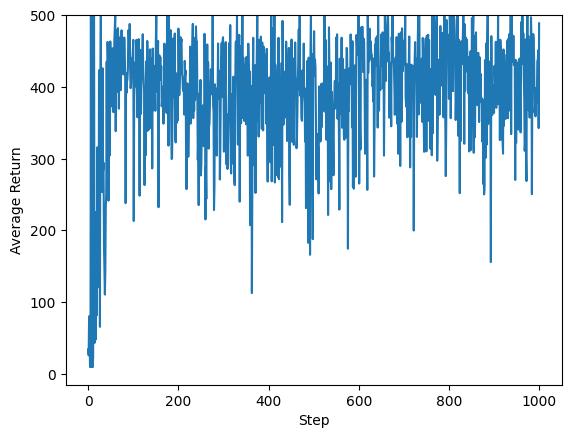

In [ ]:
steps = range(0, num_iterations + 1, 1)
# steps = range(0, num_iterations + 1, 10)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=500)